# Exact Results for the Three-Body Problem
#### The Quantum Mechanics Solver - Dalibard (21)

In this notebook I will be attempting to simulate a wavefunction within a Three-Body Harmonic Oscillator. I will use some concepts I learned in PHYS-3600: Computational Physics taught by Dr. Rau.

### Imports

In [74]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import scipy.fft
from scipy.integrate import simpson as integrate
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (4,4)

In our case, we have defined our Hamiltonian for a Three-Body Harmonic Oscillator in the following way:
\begin{equation}
\hat{H} \equiv \hat{H}_1 + \hat{H}_2 + \hat{H}_{CM} = \frac{\hat{Q}_1^2}{2m} + \frac{3}{2}\kappa \hat{R}_1^2 + \frac{\hat{Q}_2^2}{2m} + \frac{3}{2}\kappa \hat{R}_2^2 + \frac{\hat{Q}_3^2}{2m}
\end{equation}

where

$$
\newcommand{wave}{\Psi(\mathbf{r}_1, \mathbf{r}_2, \mathbf{r}_3)}
\newcommand{potential}{V(\mathbf{r}_1, \mathbf{r}_2, \mathbf{r}_3)}
\renewcommand{\O}[1]{\mathbf{\hat{#1}}}
\braket{\hat{Q}_1, \hat{Q}_2, \hat{Q}_3} = \braket{\frac{1}{\sqrt{2}}(\O{p}_1 - \O{p}_2), \frac{1}{\sqrt{6}}(2\O{p}_3 - \O{p}_1 - \O{p}_2), \frac{1}{\sqrt{3}}(\O{p}_1 + \O{p}_2 + \O{p}_3)}
$$
$$
\braket{\hat{R}_1, \hat{R}_2, \hat{R}_3} = \braket{\frac{1}{\sqrt{2}}(\O{r}_1 - \O{r}_2), \frac{1}{\sqrt{6}}(2\O{r}_3 - \O{r}_1 - \O{r}_2), \frac{1}{\sqrt{3}}(\O{r}_1 + \O{r}_2 + \O{r}_3)}
$$

For convenience I will rewrite $ \hat{H} $ in the following form

\begin{equation}
\hat{H} = \left(\frac{\hat{Q}_1^2 + \hat{Q}_2^2 + \hat{Q}_3^2}{2m} + \frac{3}{2}\kappa \left(\hat{R}_1^2 + \hat{R}_2^2\right)\right) \equiv \left(\frac{\O{p}^2}{2m} + V\right)
\end{equation}

So that we can express the TDSE as

\begin{equation}
i\hbar \frac{\partial}{\partial t}\wave = \left(\frac{\O{p}^2}{2m} + \potential\right)\wave
\end{equation}

For our wavefunction, I will use an initial state of a Gaussian wave packet: $\wave = \exp\left[-\frac{1}{2}\left(\hat{R}_1^2 + \hat{R}_2^2 + \hat{R}_3^2\right)\right]$.

In [91]:
# manually compute normalization constant of a distribution
def compute_norm(G,X):
    return 1 / np.sqrt(integrate(y=np.abs(G)**2, x=X))

# normalized Gaussian constructor
# returns 3d array of each component ( e^(r1+r2+r3) = (e^r1)(e^r2)(e^r3) )
def Ψ_r(r1,r2,r3,X):
    # Jacobi variables
    R1 = X - (r1 - r2) / np.sqrt(2)
    R2 = X - (2*r3 - r1 - r2) / np.sqrt(6)
    R3 = X - (r1 + r2 + r3) / np.sqrt(3)

    retval = []
    for R in [R1,R2,R3]:
        G = np.exp(-0.5*R**2)
        C = compute_norm(G,X)
        retval.append( C * G )
    return retval

def V_r(r1,r2,r3,κ=0.05,X=0):
    R1 = X - (r1 - r2) / np.sqrt(2)
    R2 = X - (2*r3 - r1 - r2) / np.sqrt(6)
    return (3/2)*κ*(R1**2 + R2**2)

We're solving the time-dependent Schrodinger equation (in 1D)
$$
i\hbar \frac{\partial \psi(r_1,r_2,r_3,t)}{\partial t} = 
\left(\frac{\O{p}^2}{2m} + V(r_1,r_2,r_3)\right) \psi(r_1,r_2,r_3,t)
\equiv \hat{H} \psi(r_1,r_2,r_3,t)
$$
with periodic boundary conditions on an interval $[-L/2,L/2]$. Recall that $\hat{p_\mu} \equiv -i\hbar \frac{d}{dr_\mu}$. We will use a split-step and approximate the time-evolution operator $\hat{U}(\delta_t)$ for small $\delta_t$ as
$$
\psi(r_1,r_2,r_3,t+\delta_t) =
e^{-i\delta_t \hat{H}/\hbar} \psi(r_1,r_2,r_3,t)
\approx 
e^{-i\delta_t \left(\hat{Q_1^2} + \hat{Q_2^2} + \hat{Q_3^2}\right)/(2m \hbar)}e^{-i\delta_t V(r_1,r_2,r_3)/\hbar} \psi(r_1,r_2,r_3,t)
$$

We can treat the momentum part of each body separately, since $ Q_1^2 + Q_2^2 + Q_3^2 = p_1^2 + p_2^2 + p_3^2 $. For the potential part, we need to know $r_1, r_2, r_3$ at each step. I will make a relatively bold assumption that the peak of each wave packet corresponds to its $r$.

We'll do this on a finite grid with points $r_{\mu,n} \equiv n \delta_{r_\mu}$ where $n=0,1,2,\cdots,N_x-1$ and $\delta_{r_\mu} = L/N_x$.

We will also leverage FFT's from `scipy.fft` for calculating our momentum steps

In [92]:
def fft_fwd(ψ,L=1.0): # from ψ to ψ tilde
    Nx = len(ψ)
    ψt = 1.0/Nx*scipy.fft.fft(ψ*(-1)**np.arange(0,Nx))
    return ψt    

def fft_bwd(ψt,L=1.0): # ψ tilde -> ψ
    Nx = len(ψt)
    ψ = Nx*scipy.fft.ifft(ψt)*(-1)**np.arange(0,Nx)
    return ψ

In [103]:
def potential_step(ψ0, # complex array of size Nx
                   V0, # real array of size Nx
                   X,  # real array of size Nx
                   δt, # time step
                   ħ=1.0):
    ψ = np.exp(-1j*V0*δt/ħ)*ψ0 # element-wise multiplication

    # update potential
    Nx = len(X)
    ψ01,ψ02,ψ03 = ψ0
    r1,r2,r3 = X[np.argmax(ψ01)],X[np.argmax(ψ02)],X[np.argmax(ψ03)] # assume r1,r2,r3 are the max of each distribution
    r1,r2,r3 = np.linspace(0,r1,Nx), np.linspace(0,r2,Nx), np.linspace(0,r3,Nx) 
    V = np.full(Nx, V_r(r1,r2,r3))
    
    return ψ,V

def kinetic_step(ψ0, # complex array of size Nx
                 δt, # time step
                 ħ=1,L=1,m=1):
    Nx = len(ψ0)
    
    # to momentum space
    ψt1 = fft_fwd(ψ0,L=L)
    
    # evolved in momentum space
    K = 2.0*np.pi/L*np.arange(-Nx//2,Nx//2)
    E = ħ**2*K**2/(2*m) # energy of a wave packet = ħ^2 k^2 / 2m
    ψt2 = np.exp(-1j*δt/ħ*E)*ψt1
    
    # from momentum space    
    return fft_bwd(ψt2,L=L)

In [104]:
# step method
def verlet_split(ψ0,V0,X,δt,ħ=1,m=1,L=1):    
    χ1,V1  = potential_step(ψ0,V0,X,0.5*δt,ħ=ħ)   

    # compute for r1,r2,r3
    χ2 = []
    for χ in χ1:
        χ2i    = kinetic_step(χ,δt,ħ=ħ,m=m,L=L)
        C      = compute_norm(χ2i,X)
        χ2.append(C * χ2i)
    
    χ3,V = potential_step(χ2,V1,X,0.5*δt,ħ=ħ)
    return χ3,V

# evolver
def evolve_split_step(ψ0,V0,X,δt,Nt,L=1.0,m=1.0,ħ=1.0,step=verlet_split):
    Nx = len(X)
    T = np.linspace(0,Nt*δt,Nt,endpoint=False)
    Ψ = np.zeros((3,Nx,Nt),dtype=np.complex128)
    V = np.zeros((Nx,Nt),dtype=np.complex128)
    
    Ψ[:,:,0] = ψ0
    V[:,0] = V0
    for it in range(Nt-1):
        Ψ[:,:,it+1],V[:,it+1] = step(Ψ[:,:,it],V[:,it],X,δt,ħ=ħ,m=m,L=L)
    return T,Ψ,V

Text(0.5, 0, 'x')

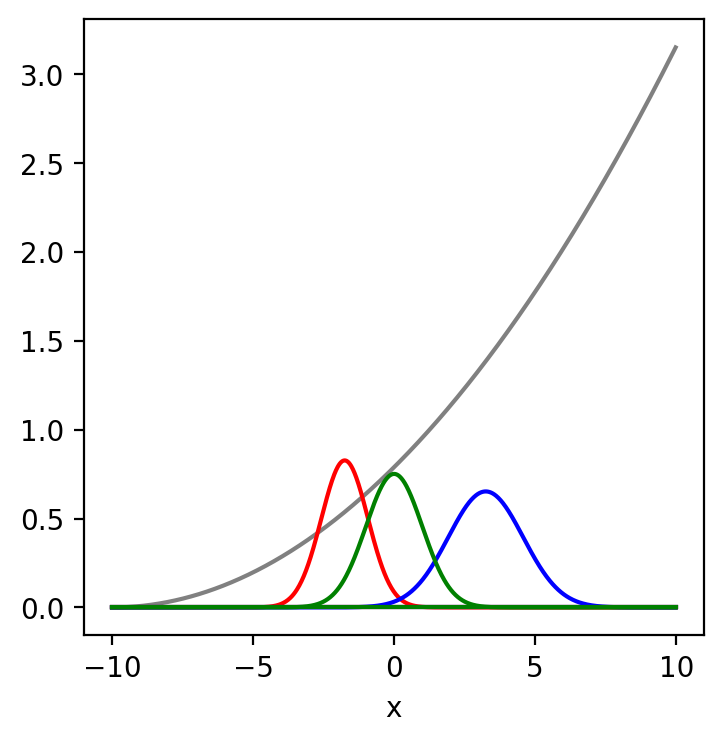

In [108]:
L  = 20
Nx = 1000
X = np.linspace(-L/2,L/2,Nx,endpoint=False)

# initial conditions
r1,r2,r3 = -5,1,4
r1,r2,r3 = np.linspace(0,r1,Nx), np.linspace(0,r2,Nx), np.linspace(0,r3,Nx)
V0 = V_r(r1,r2,r3)
V = np.full(Nx,V0)

ψ01,ψ02,ψ03 = Ψ_r(r1,r2,r3,X)

tf  = 8*np.pi
Nt = 5000
δt = tf/Nt

plt.plot(X,V,color='gray')
plt.plot(X,np.real(ψ01),color='r')
plt.plot(X,np.imag(ψ01),color='r')
plt.plot(X,np.real(ψ02),color='b')
plt.plot(X,np.imag(ψ02),color='b')
plt.plot(X,np.real(ψ03),color='g')
plt.plot(X,np.imag(ψ03),color='g')
#plt.ylim(-0.5,1.5)
#plt.xlim(-10,10)
plt.xlabel('x')

In [109]:
%time T,Ψ,V = evolve_split_step([ψ01,ψ02,ψ03],V,X,δt,Nt,L=L)

CPU times: total: 3.5 s
Wall time: 6.85 s


In [116]:
import ipywidgets as widgets
@widgets.interact(t=(0.0,tf,δt))
def disp(t=0):
    it = int(t/tf*(Nt-1))
    for i,color in zip(range(3),['r','b','g']):
        φ = V[:,it]
        ψ = Ψ[i,:,it]
        plt.plot(X,φ,color='gray')
        #plt.plot(X,np.real(ψ),color=color)
        #plt.plot(X,np.imag(ψ),color=color)
        plt.plot(X,np.abs(ψ),color=color)
    plt.ylim(-0.5,1)
    plt.xlim(-L/2,L/2)

interactive(children=(FloatSlider(value=0.0, description='t', max=25.132741228718345, step=0.00502654824574366…